# Alpaca Hum Segmentation – Benchmark Insights

**Notebook goal** – Load `metrics.csv` produced by `evaluate_benchmark.py`,
visualise and compare model variants across thresholds:

* Overall leaderboard (F1, precision, recall)
* F1 vs. classification threshold curves for each model
* Precision–Recall scatter
* Boundary‐error (Δstart/Δend) distribution
* Call‐rate correlation (Pearson vs. Spearman)
* Q1‐only recall heat‑map

In [51]:
import re
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_context("talk")

In [52]:
METRICS_CSV = Path("metrics.csv")  # adjust if saved elsewhere
assert METRICS_CSV.exists(), f"{METRICS_CSV} not found"

In [53]:
df = pd.read_csv(METRICS_CSV)

def parse_variant_tag(tag: str):
    """return seq_len (ms), hop (ms), threshold (float)"""
    m = re.match(r"len(\d+)_hop(\d+)_th(\d+)", tag)
    if not m:
        return None, None, None
    seq = int(m[1]) / 1000  # back to s
    hop = int(m[2]) / 1000
    th = int(m[3]) / 100
    return seq, hop, th

df[["seq_len_s", "hop_s", "threshold"]] = (
    df["variant"].apply(lambda t: pd.Series(parse_variant_tag(t)))
)

In [54]:
leader_cols = [
    "model",
    "variant",
    "precision",
    "recall",
    "f1",
    "mean_dstart_ms",
    "mean_dend_ms",
]
leader = df[leader_cols].sort_values("f1", ascending=False)
leader.head(20)

,model,variant,precision,recall,f1,mean_dstart_ms,mean_dend_ms
2,v3_tape_proportional,len500_hop050_th90,0.111695,0.469613,0.180467,183.447059,218.235294
4,v3_tape_proportional,len500_hop050_th80,0.053917,0.353591,0.093567,214.843750,247.546875
0,v3_tape_proportional,len500_hop050_th70,0.023148,0.138122,0.039651,257.120000,270.240000
11,v2_quality,len500_hop050_th90,0.019409,0.243094,0.035948,219.454545,330.454545
7,v3_tape_proportional,len500_hop050_th50,0.015326,0.243094,0.028834,238.477273,289.568182
1,v3_tape_proportional,len500_hop050_th40,0.012393,0.232044,0.023529,243.523810,296.309524
8,v3_tape_proportional,len500_hop050_th60,0.011546,0.127072,0.021169,266.173913,281.391304
3,v3_tape_proportional,len500_hop050_th30,0.009228,0.193370,0.017614,277.428571,308.085714
13,v2_quality,len500_hop050_th80,0.007210,0.149171,0.013754,277.777778,340.444444
5,v3_tape_proportional,len500_hop050_th20,0.006522,0.149171,0.012497,298.666667,287.407407


### Recall vs. threshold for each model

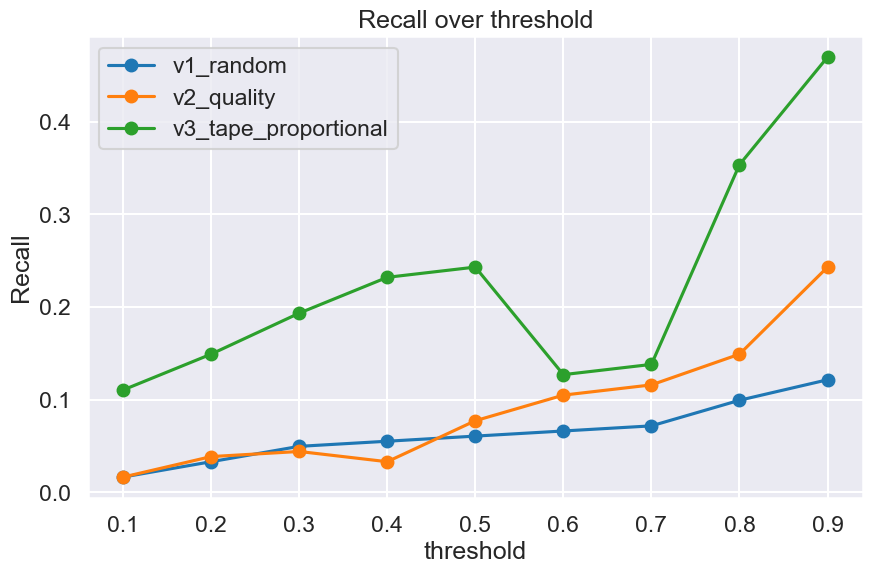

In [55]:
plt.figure(figsize=(10, 6))
for model, sub in df.groupby("model"):
    sub_sorted = sub.sort_values("threshold")
    plt.plot(sub_sorted["threshold"], sub_sorted["recall"], "-o", label=model)
plt.xlabel("threshold")
plt.ylabel("Recall")
plt.title("Recall over threshold")
plt.legend()
plt.grid(True)
plt.show()

## Recall vs. threshold for each quality (Q1–Q4)

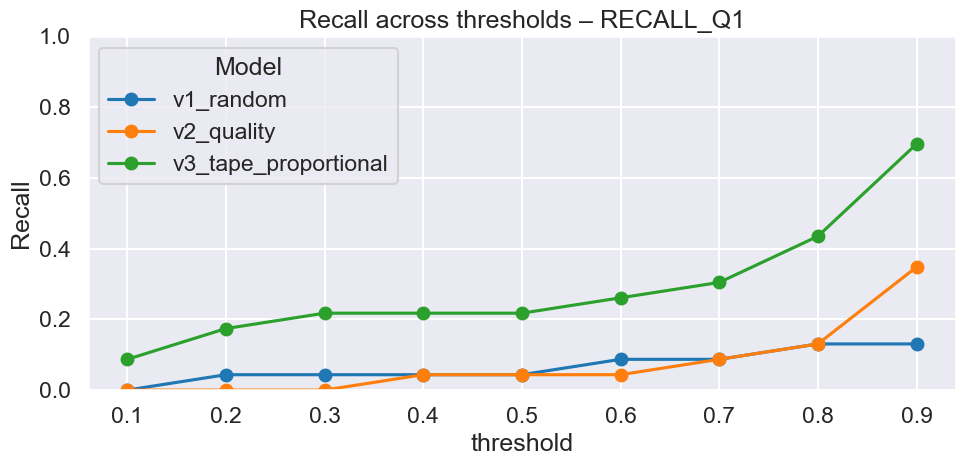

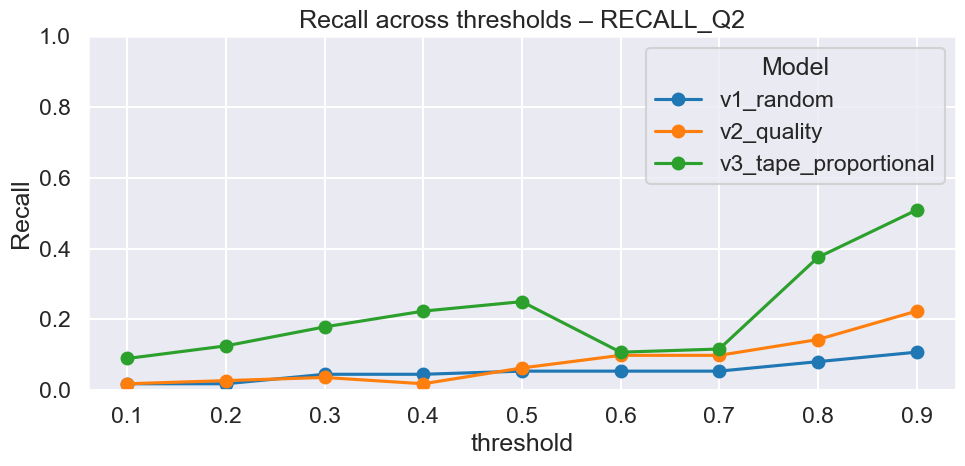

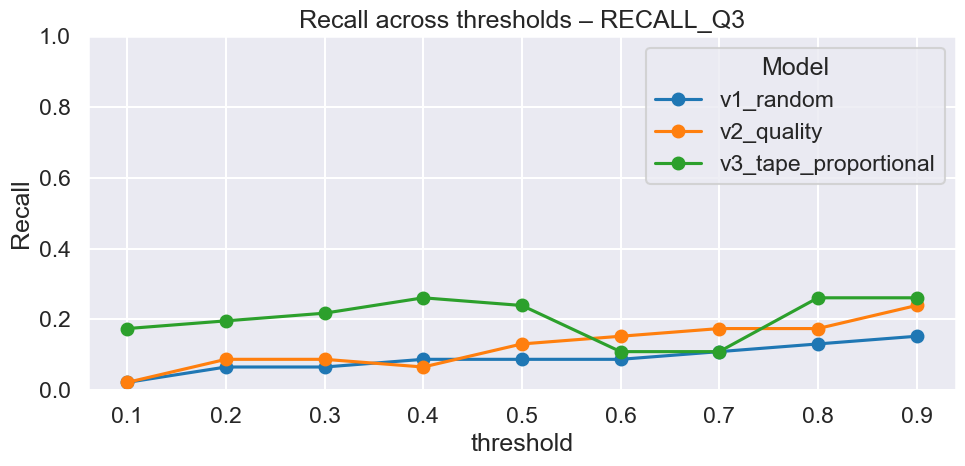

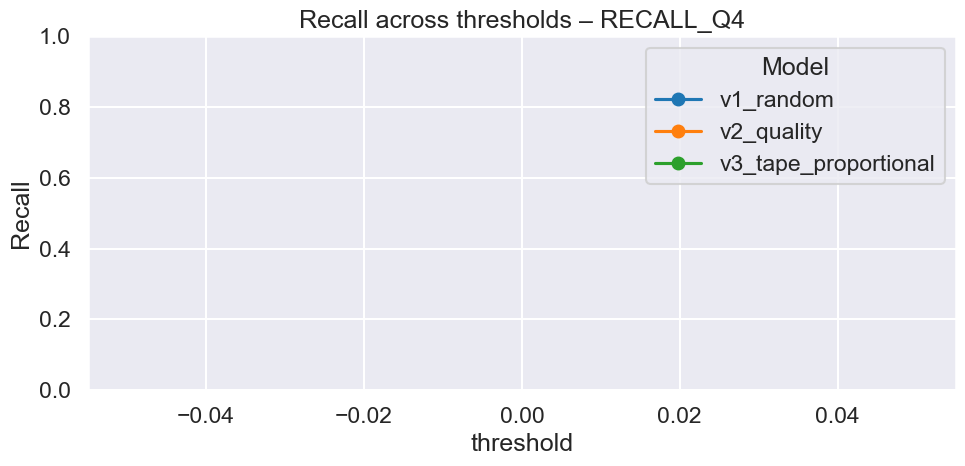

In [56]:
qualities = ["recall_q1", "recall_q2", "recall_q3", "recall_q4"]

for q in qualities:
    if q in df.columns:
        plt.figure(figsize=(10, 5))
        for model, sub in df.groupby("model"):
            sub_sorted = sub.sort_values("threshold")
            plt.plot(
                sub_sorted["threshold"],
                sub_sorted[q],
                marker="o",
                label=model
            )
        plt.title(f"Recall across thresholds – {q.upper()}")
        plt.xlabel("threshold")
        plt.ylabel("Recall")
        plt.ylim(0, 1)
        plt.grid(True)
        plt.legend(title="Model")
        plt.tight_layout()
        plt.show()

### Detected calls vs. threshold (log scale)

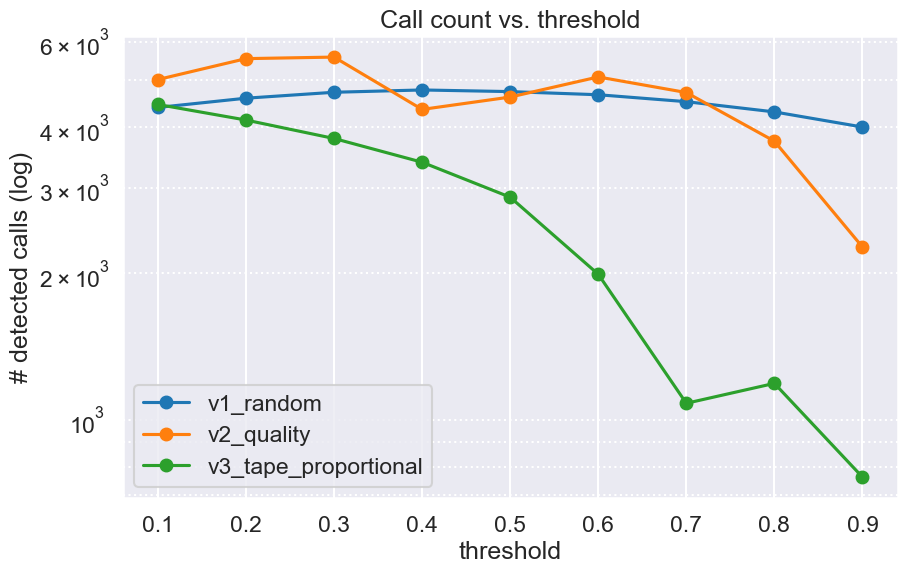

In [57]:
plt.figure(figsize=(10, 6))
for model, sub in df.groupby("model"):
    sub_sorted = sub.sort_values("threshold")
    plt.plot(sub_sorted["threshold"], sub_sorted["n_pred"], "-o", label=model)
plt.xlabel("threshold")
plt.ylabel("# detected calls (log)")
plt.yscale("log")
plt.title("Call count vs. threshold")
plt.legend()
plt.grid(True, which="both", axis="y", linestyle=":")
plt.show()

### Top‑5 variants by F1

In [58]:
leader.head(5).style.format({"precision": "{:.2%}", "recall": "{:.2%}", "f1": "{:.2%}"})

,model,variant,precision,recall,f1,mean_dstart_ms,mean_dend_ms
2,v3_tape_proportional,len500_hop050_th90,11.17%,46.96%,18.05%,183.447059,218.235294
4,v3_tape_proportional,len500_hop050_th80,5.39%,35.36%,9.36%,214.843750,247.546875
0,v3_tape_proportional,len500_hop050_th70,2.31%,13.81%,3.97%,257.120000,270.240000
11,v2_quality,len500_hop050_th90,1.94%,24.31%,3.59%,219.454545,330.454545
7,v3_tape_proportional,len500_hop050_th50,1.53%,24.31%,2.88%,238.477273,289.568182


### F1 vs. threshold curve for each model

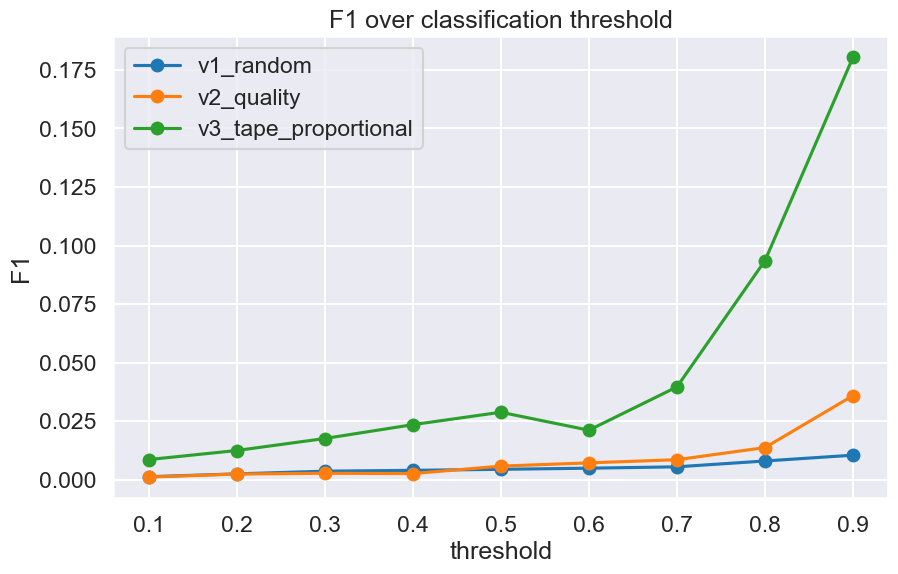

In [59]:
plt.figure(figsize=(10, 6))
for model, sub in df.groupby("model"):
    sub_sorted = sub.sort_values("threshold")
    plt.plot(sub_sorted["threshold"], sub_sorted["f1"], "-o", label=model)
plt.xlabel("threshold")
plt.ylabel("F1")
plt.title("F1 over classification threshold")
plt.legend()
plt.grid(True)
plt.show()

### F1 per quality level (Q1–Q4) across thresholds

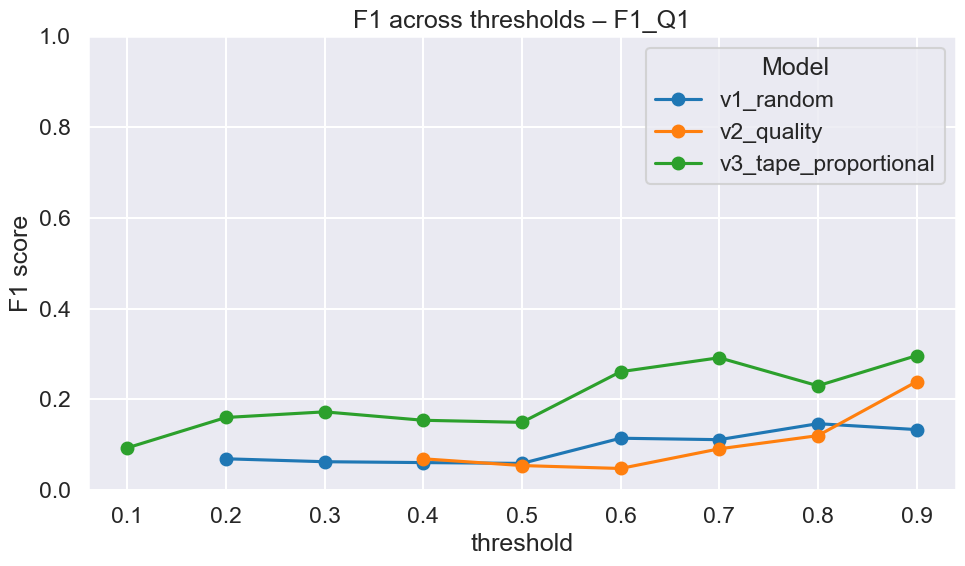

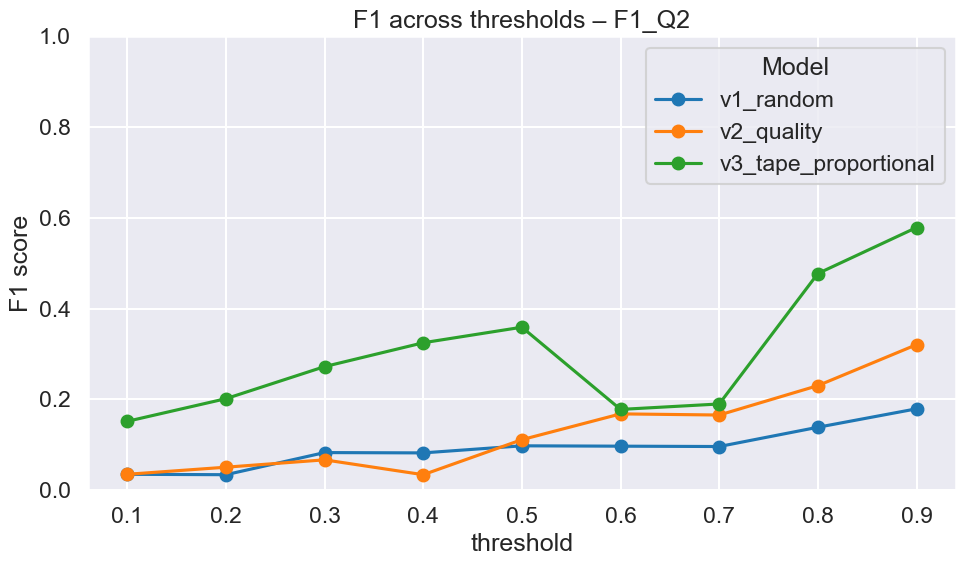

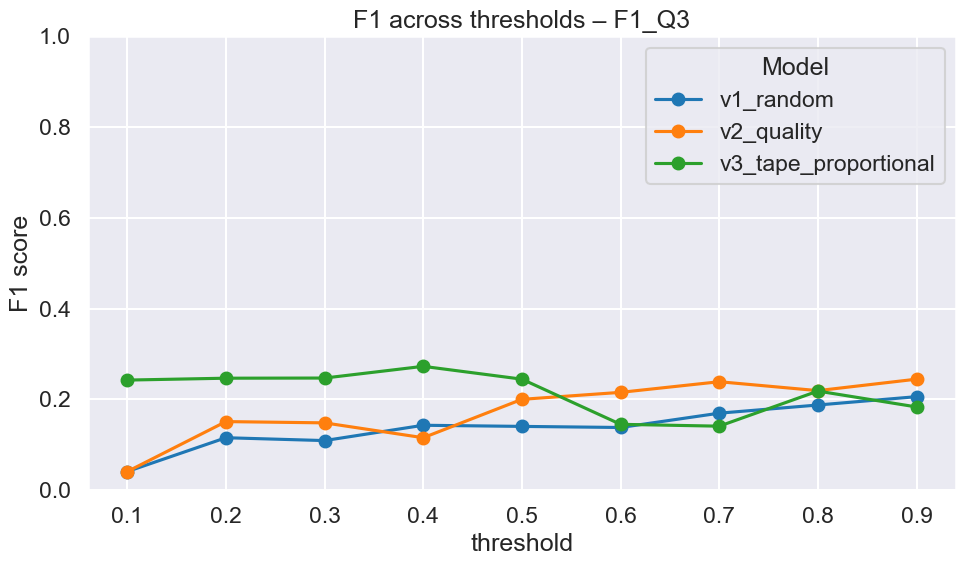

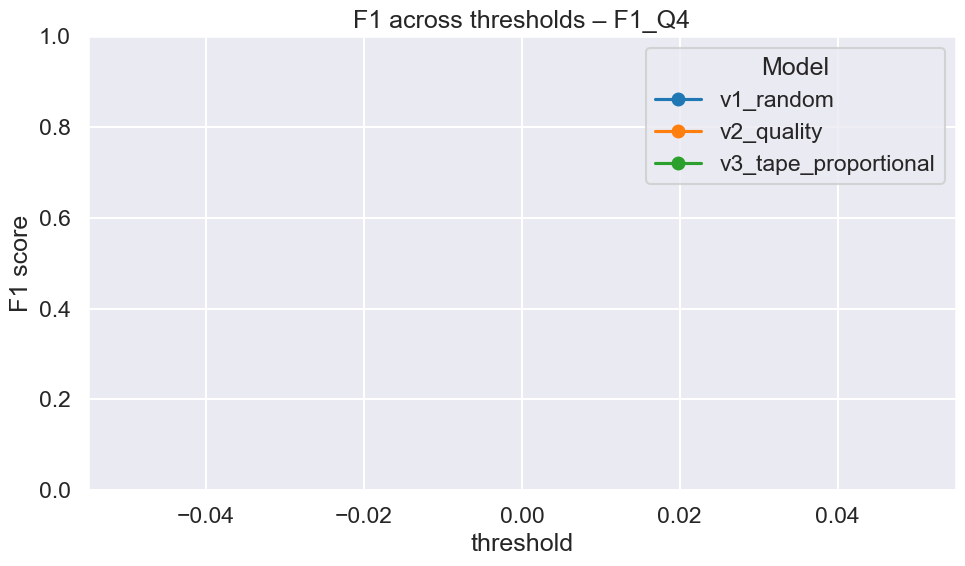

In [60]:
qualities = ["f1_q1", "f1_q2", "f1_q3", "f1_q4"]

for q in qualities:
    if q in df.columns:
        plt.figure(figsize=(10, 6))
        for model, sub in df.groupby("model"):
            sub_sorted = sub.sort_values("threshold")
            plt.plot(
                sub_sorted["threshold"],
                sub_sorted[q],
                marker="o",
                label=model
            )
        plt.xlabel("threshold")
        plt.ylabel("F1 score")
        plt.title(f"F1 across thresholds – {q.upper()}")
        plt.ylim(0, 1)
        plt.grid(True)
        plt.legend(title="Model")
        plt.tight_layout()
        plt.show()

### Precision vs. Recall scatter

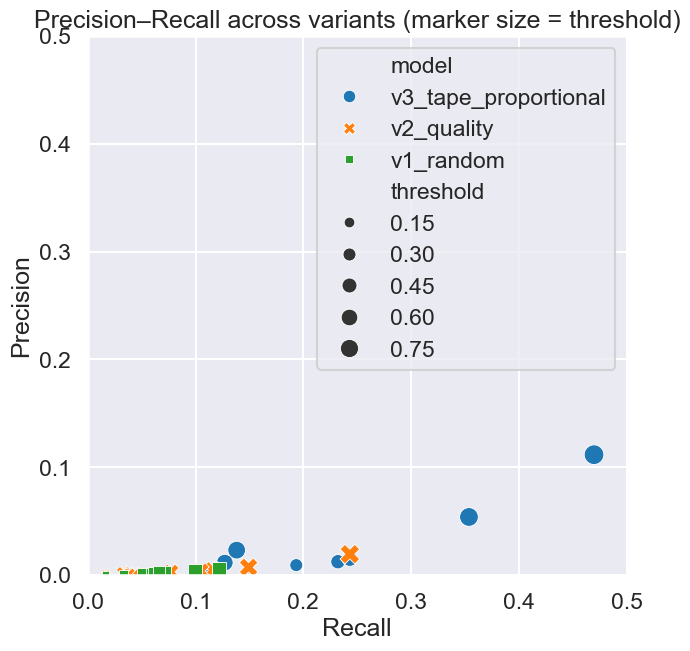

In [61]:
plt.figure(figsize=(7, 7))
ax = sns.scatterplot(
    data=df,
    x="recall",
    y="precision",
    hue="model",
    style="model",
    size="threshold",
    sizes=(50, 200),
)
ax.set(xlim=(0, 0.5), ylim=(0, 0.5), xlabel="Recall", ylabel="Precision")
ax.set_aspect("equal")
plt.title("Precision–Recall across variants (marker size = threshold)")
plt.grid(True)
plt.show()

### Boundary error distributions

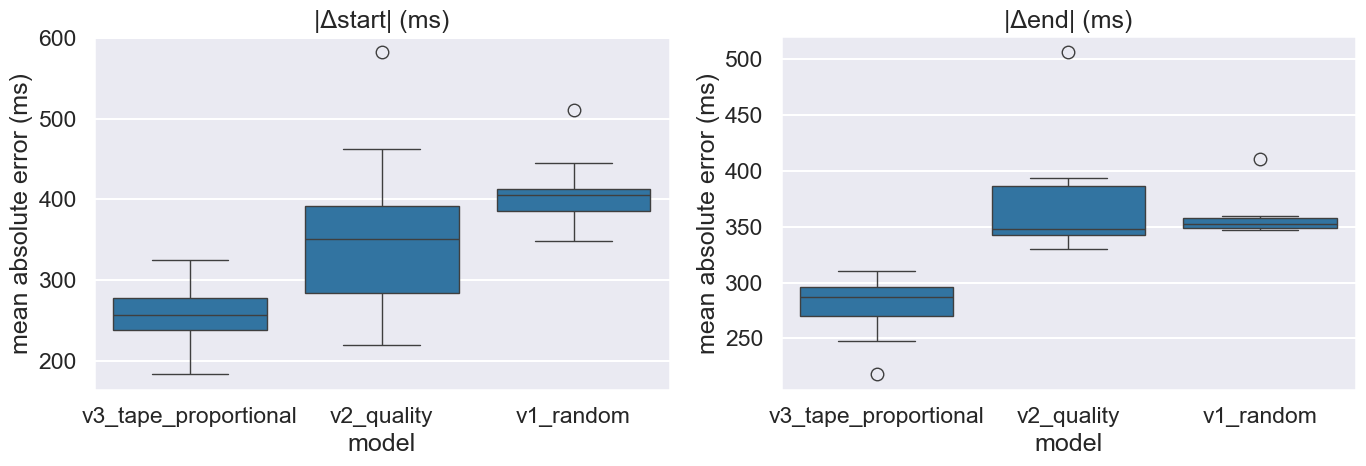

In [62]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(x="model", y="mean_dstart_ms", data=df, ax=axs[0])
axs[0].set_title("|Δstart| (ms)")
axs[0].set_ylabel("mean absolute error (ms)")

sns.boxplot(x="model", y="mean_dend_ms", data=df, ax=axs[1])
axs[1].set_title("|Δend| (ms)")
axs[1].set_ylabel("mean absolute error (ms)")

plt.tight_layout()
plt.show()

### Call‑rate correlation

/opt/homebrew/Caskroom/miniforge/base/envs/alpaca-hums/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


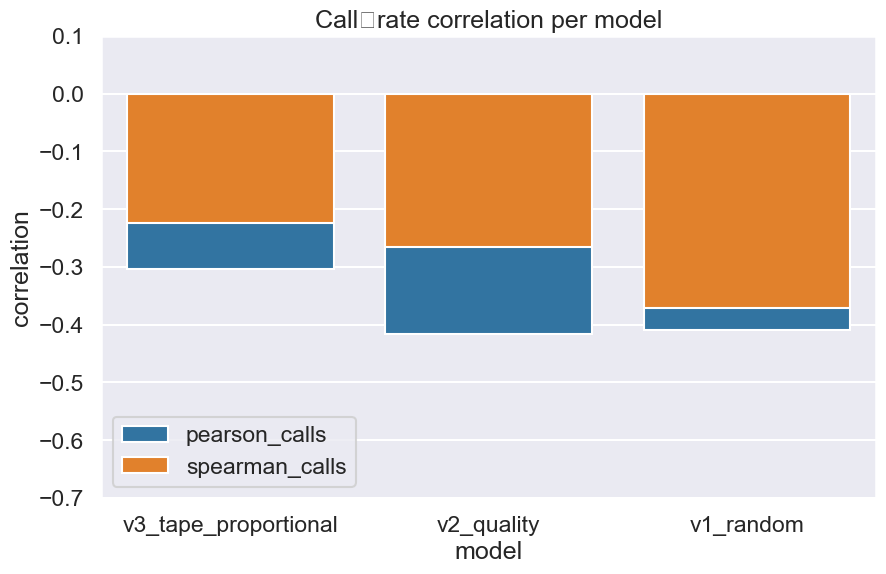

In [63]:
plt.figure(figsize=(10, 6))
for corr in ["pearson_calls", "spearman_calls"]:
    sns.barplot(x="model", y=corr, data=df, errorbar=None, label=corr)
plt.ylabel("correlation")
plt.ylim(-0.7, 0.1)  # Adjusted to show negative values
plt.title("Call‑rate correlation per model")
plt.legend()
plt.show()